In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg

## Load projected temperature data

### add Status column

In [2]:
train = pd.read_csv('Kyoto_filled.csv')
train['doy'] = pd.to_datetime(train['DATE']).dt.dayofyear

In [3]:
train.head()

,location,lat,long,alt,year,bloom_date,bloom_doy,DATE,SNWD,PRCP,TAVG,TMAX,TMIN,Status,CDD,doy
0,kyoto,35.011983,135.676114,44.0,1953,1953-04-11,101.0,1953-02-01,NaN,0.4,0.6,4.9,-2.4,0.0,0.6,32
1,kyoto,35.011983,135.676114,44.0,1953,1953-04-11,101.0,1953-02-02,NaN,0.1,1.4,6.2,-3.5,0.0,2.0,33
2,kyoto,35.011983,135.676114,44.0,1953,1953-04-11,101.0,1953-02-03,NaN,0.0,2.1,7.4,-1.4,0.0,4.1,34
3,kyoto,35.011983,135.676114,44.0,1953,1953-04-11,101.0,1953-02-04,NaN,0.0,2.2,4.7,-1.4,0.0,6.3,35
4,kyoto,35.011983,135.676114,44.0,1953,1953-04-11,101.0,1953-02-05,NaN,0.0,2.7,8.4,0.4,0.0,9.0,36


In [4]:
train.tail()

,location,lat,long,alt,year,bloom_date,bloom_doy,DATE,SNWD,PRCP,TAVG,TMAX,TMIN,Status,CDD,doy
25207,NaN,NaN,NaN,NaN,2022,NaN,NaN,2022-02-06,NaN,2.805932,2.4,7.261971,-0.700000,NaN,152.2,37
25208,NaN,NaN,NaN,NaN,2022,NaN,NaN,2022-02-07,NaN,0.000000,4.6,8.400000,-0.400000,NaN,156.8,38
25209,NaN,NaN,NaN,NaN,2022,NaN,NaN,2022-02-08,NaN,0.500000,5.5,11.400000,0.760457,NaN,162.3,39
25210,NaN,NaN,NaN,NaN,2022,NaN,NaN,2022-02-09,NaN,0.000000,5.9,11.000000,1.500000,NaN,168.2,40
25211,NaN,NaN,NaN,NaN,2022,NaN,NaN,2022-02-10,NaN,0.000000,5.8,9.400000,1.235101,NaN,174.0,41


In [5]:
train.describe()

,lat,long,alt,year,bloom_doy,SNWD,PRCP,TAVG,TMAX,TMIN,Status,CDD,doy
count,2.517100e+04,2.517100e+04,25171.0,25212.000000,25171.000000,0.0,25212.000000,25212.000000,25212.000000,25212.000000,25171.000000,25212.000000,25212.000000
mean,3.501198e+01,1.356761e+02,44.0,1987.099397,97.518295,NaN,4.662759,15.851877,20.801782,11.089024,0.736641,2613.237896,183.065286
std,1.615096e-11,6.508701e-11,0.0,19.926818,4.494840,NaN,12.282140,8.649944,8.928032,8.747054,0.440464,2043.370384,105.459208
min,3.501198e+01,1.356761e+02,44.0,1953.000000,85.000000,NaN,-13.745548,-3.000000,0.300000,-8.100000,0.000000,0.500000,1.000000
25%,3.501198e+01,1.356761e+02,44.0,1970.000000,95.000000,NaN,0.000000,7.900000,12.800000,2.900000,0.000000,558.575000,92.000000
50%,3.501198e+01,1.356761e+02,44.0,1987.000000,98.000000,NaN,0.000000,16.200000,21.200000,10.900000,1.000000,2290.134495,183.000000
75%,3.501198e+01,1.356761e+02,44.0,2004.000000,99.000000,NaN,4.333951,23.300000,28.200000,18.900000,1.000000,4675.066182,274.000000
max,3.501198e+01,1.356761e+02,44.0,2022.000000,110.000000,NaN,288.600000,33.350000,39.800000,28.841998,1.000000,6263.550000,366.000000


## add prediction data

In [6]:
prediction_ds = pd.read_csv('Kyoto_temp_forecast_10_years.csv')
prediction_ds['doy'] = pd.to_datetime(prediction_ds['date']).dt.dayofyear
prediction_ds['year'] = pd.to_datetime(prediction_ds['date']).dt.year
prediction_ds['CDD'] = (prediction_ds.groupby(['year']))['temp'].cumsum()
prediction_ds.head()

,Unnamed: 0,temp,date,doy,year,CDD
0,1.0,2.3,1/1/22,1,2022,2.3
1,2.0,4.8,1/2/22,2,2022,7.1
2,3.0,5.4,1/3/22,3,2022,12.5
3,4.0,4.3,1/4/22,4,2022,16.8
4,5.0,3.8,1/5/22,5,2022,20.6


## Training using temperature 1954 - 2021

In [7]:
# return the upper and lower bound near p_doy, from year start to year end
def p_doy_bound(start, end):
    
    # return upper, lower, beta0, beta1, beta2
    upper = np.zeros(end - start + 1)
    lower = np.zeros(end - start + 1)
    beta0 = np.zeros(end - start + 1)
    beta1 = np.zeros(end - start + 1)
    beta2 = np.zeros(end - start + 1)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # create data column
        train_year = train[train['year'] == year][:180]
        features = ['doy', 'CDD']
        X = train_year[features]
        y = train_year.Status
        
        # fitting
        pred_model = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
        pred_model.fit(X, y)
        beta = pred_model.coef_
        
        # get probability vs. doy function
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, beta.T) - pred_model.intercept_)))
        
        # get upper and lower bound
        day_bloom = int(np.array(train_year['bloom_doy'])[0])
        
        for i in range(180):
            if p_days[i + 1, 0] > 0.5:
                lower[year - start] = p_days[i, 0]
                upper[year - start] = p_days[i + 1, 0]
                break
                
        beta0[year - start] = pred_model.intercept_[0]
        beta1[year - start] = beta[0, 0]
        beta2[year - start] = beta[0, 1]
        
    return upper, lower, beta0, beta1, beta2

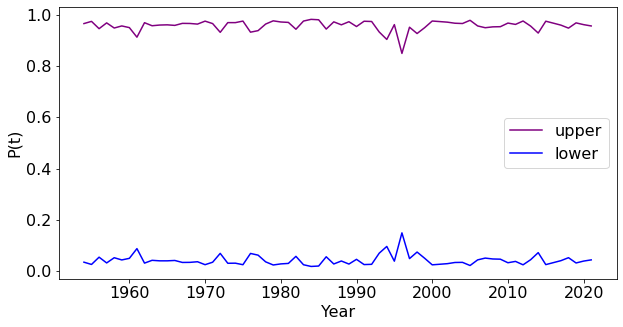

In [8]:
# plot the upper, lower bound vs. year
start = 1954
end = 2021
result = p_doy_bound(start, end)
x = np.arange(start, end + 1)

plt.figure(figsize=(10, 5))
plt.plot(x, result[0], color = 'purple', label = 'upper')
plt.plot(x, result[1], color = 'blue', label = 'lower')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("P(t)", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

In [9]:
print(result[2])
print(result[3])
print(result[4])

[-323.71420722 -289.6457303  -337.56065579 -303.4420661  -350.66137203
 -325.13541208 -323.91820983 -353.67551417 -289.04436456 -236.21847292
 -307.96407384 -321.71995628 -332.11044264 -291.70736576 -272.94839999
 -316.89568902 -284.31171083 -307.41974467 -463.84163154 -332.81289346
 -259.44175571 -253.38375244 -386.39185793 -278.83999609 -322.30720567
 -308.16428079 -276.42064678 -252.4211227  -316.53894315 -277.59668759
 -195.68499792 -251.47008709 -307.52113317 -270.43050902 -359.28427834
 -304.00773233 -327.81364652 -277.9805892  -293.99359495 -409.51124425
 -413.33949874 -324.80552185 -439.11560018 -356.10773458 -405.82833654
 -357.68467068 -273.10965216 -262.96476449 -310.12177135 -288.30154115
 -296.40092412 -265.18391949 -314.52377407 -399.11155012 -315.53406568
 -359.57293842 -311.64055411 -289.05577368 -255.07950806 -308.97081148
 -378.54307552 -281.03928316 -350.96257848 -340.37520626 -318.99185505
 -328.26786341 -392.38401132 -346.66911718]
[0.03564289 0.02670293 0.05522281

## $\beta_i$ prediction

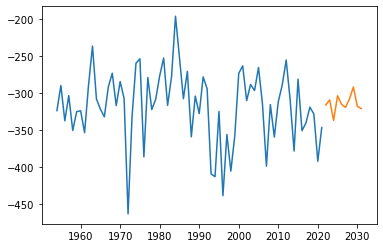

In [10]:
beta0_model = AutoReg(result[2], lags = 10, trend='c').fit()
plt.plot(range(1954, 2021+1), result[2])
plt.plot(range(2022, 2031+1), beta0_model.predict(2022-1954, 2031-1954, dynamic=False))
plt.show()

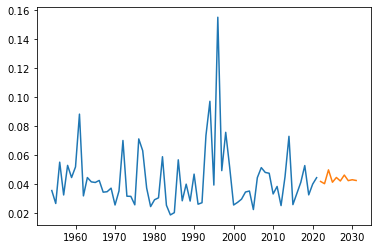

In [11]:
beta1_model = AutoReg(result[3], lags = 10, trend='c').fit()
plt.plot(range(1954, 2021+1), result[3])
plt.plot(range(2022, 2031+1), beta1_model.predict(2022-1954, 2031-1954, dynamic=False))
plt.show()

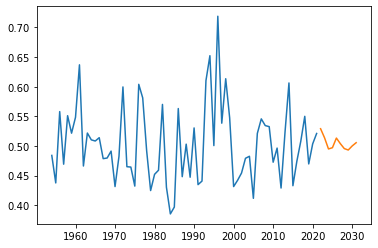

In [12]:
beta2_model = AutoReg(result[4], lags = 7, trend='c').fit()
plt.plot(range(1954, 2021+1), result[4])
plt.plot(range(2022, 2031+1), beta2_model.predict(2022-1954, 2031-1954, dynamic=False))
plt.show()

## predict doy for 2022 - 2031

In [13]:
beta0_model = AutoReg(result[2], lags = 1, trend='c').fit()
beta1_model = AutoReg(result[3], lags = 10, trend='c').fit()
beta2_model = AutoReg(result[4], lags = 7, trend='c').fit()
# predict the blooming doy
# return the predicted doy
def predict_blooming_beta_ts(start, end):
    
    training_start = 1954
    
    predict = np.zeros(end - start + 1)
    
    beta0_pre = beta0_model.predict(start-training_start, end-training_start, dynamic=False)
    beta1_pre = beta1_model.predict(start-training_start, end-training_start, dynamic=False)
    beta2_pre = beta2_model.predict(start-training_start, end-training_start, dynamic=False)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # build the predict doy array
        if year >= start + 1:
            CU = np.average(prediction_ds[prediction_ds['year'] == year - 1][-71:]['temp'])
        else:
            CU = np.average(train[train['year'] == year - 1][-71:]['TAVG'])
        
        pre_year = prediction_ds[prediction_ds['year'] == year][:180]
        features = ['doy', 'CDD']
        X = pre_year[features]
        
        # time series predict beta_i
        b = np.array([[beta1_pre[year - start], beta2_pre[year - start]]])
        # b0 = np.array([beta0_pre[year - start]])
        if CU < 9:
            b0 = np.array([beta0_pre[year - start] + 50])
        else:
            b0 = np.array([beta0_pre[year - start]])
        
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, b.T) - b0)))
        
        for i in range(180):
            if p_days[i, 0] > 0.5:
                predict[year - start] = i + 1
                break
        
    return predict


[ 95.  99. 101.  93.  94.  93.  95.  99.  89.  95.  92.  85.]


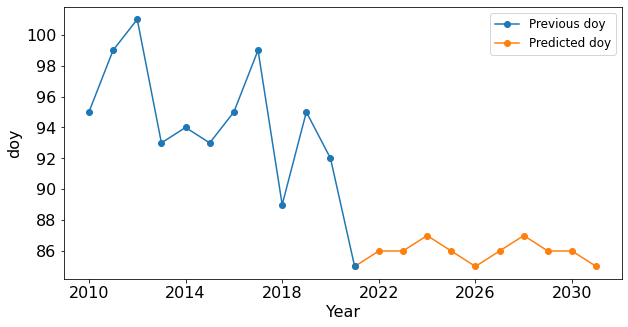

In [14]:
# plot the predict, real doy vs. year
start = 2022
end = 2031
result_pred_ts = predict_blooming_beta_ts(start, end)
x_r = np.arange(2010, 2021 + 1)
x_p = np.arange(start, end + 1)

show_start = 2010
show_end = 2021
day_bloom_array = np.zeros(show_end - show_start + 1)
for y in range(show_start, show_end + 1):
    train_y = train[train['year'] == y]
    day_bloom_array[y - show_start] = int(np.array(train_y['bloom_doy'])[0])
print(day_bloom_array)

f = plt.figure(figsize=(10, 5))
plt.plot(x_r, day_bloom_array, 'o-', label = 'Previous doy')
# plt.plot(x_p, result_pred_ts, 'o-', label = 'Predicted doy')
plt.plot(np.arange(start - 1, end + 1), np.insert(result_pred_ts, 
                                    0, day_bloom_array[-1]), 'o-', label = 'Predicted doy', zorder = 1)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("doy", fontsize = 16)
plt.xticks(np.arange(2010, 2033, 4), fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 12, loc = 'upper right')
plt.show()
# f.savefig("../result_figures/kyoto_prediction.png", bbox_inches='tight', dpi=1200)

In [15]:
print(result_pred_ts)

[86. 86. 87. 86. 85. 86. 87. 86. 86. 85.]
